# VQA Model
This is a backend for the splitted model. It can use pretrained vgg-16 or resnet-50 embeddings for vision and Google Universal Sentence Encoder for language.

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, utils
import json
import tqdm
import numpy as np
import time
from datetime import timedelta


# Data transfer to local disk

Mounting shared Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/aidl/lib')

Mounted at /content/drive


Copy precomputed embeddings from GoogleDrive to the local disk

In [ ]:
# vgg
!cp '/content/drive/My Drive/aidl/'full_embeddings.zip .
!unzip full_embeddings.zip
# resnet50
#!cp '/content/drive/My Drive/aidl/'r50_embeddings.zip .
#!unzip r50_embeddings.zip

Archive:  full_embeddings.zip
  inflating: annotation_map.save     
  inflating: image_embeddings_train.save  
  inflating: question_embeddings_train.save  
  inflating: annotations_train.save  
  inflating: metadatas_train.save    
  inflating: image_embeddings_test.save  
  inflating: question_embeddings_test.save  
  inflating: annotations_test.save   
  inflating: metadatas_test.save     


# VQA Model

Global Parameters

In [ ]:
batch_size = 400
num_epochs = 100
learning_rate = 1.0e-03 / 0.95 ** 3
lmbda = lambda epoch: 0.95 ** (epoch // (num_epochs // 10))

dataset_root = "/content"

!ls '$dataset_root'
device = torch.device('cuda')

annotation_map.save	    image_embeddings_train.save
annotations_test.save	    metadatas_test.save
annotations_train.save	    metadatas_train.save
drive			    question_embeddings_test.save
full_embeddings.zip	    question_embeddings_train.save
image_embeddings_test.save  sample_data


Utility functions

In [ ]:
from datetime import datetime
import pytz

# Get a string YYYYMMDDHHMMSS to timestamp the torch.save files

def getTimestamp():
    tz = pytz.timezone("Europe/Madrid")
    
    return datetime.now(tz).strftime("%Y%m%d%H%M%S")

 VQA Model definition

Parameters:
- D_in1 : *image embedding size*
- D_in2 : *question embedding size*
- E     : *Combined embedding size*
- H     : *Classifier hidden layer size*
- D_out : *Classifier output size*

In [ ]:
import torch.nn.functional as F

class VQAm1(nn.Module):
    def __init__(self, D_in1, D_in2, E,  H, D_out):
        super().__init__()

        self.iEmbedding = nn.Sequential(
                              nn.Linear(D_in1, E),
                              nn.ReLU(),
                          )
        
        self.qEmbedding = nn.Sequential(
                              nn.Linear(D_in2, E),
                              nn.ReLU(),
                          )
        """ 2 hidden layers classifier 
        self.model = nn.Sequential(
                          nn.Dropout(p=0.5),
                          nn.Linear(E, 2*H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=2*H),
                          nn.Dropout(p=0.5),
                          nn.Linear(2*H, H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=H),
                          nn.Dropout(p=0.5),
                          nn.Linear(H, D_out)
        )
        """
        self.model = nn.Sequential(
                          nn.Dropout(p=0.5),
                          nn.Linear(E, H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=H),
                          nn.Dropout(p=0.5),
                          nn.Linear(H, D_out)
        )


    def forward(self, x1, x2):
        imageEmbedding = F.normalize(self.iEmbedding(x1))
        questionEmbedding = F.normalize(self.qEmbedding(x2))

        combEmbedding = imageEmbedding * questionEmbedding      # pointwise
#       combEmbedding = torch.cat((imageEmbedding,questionEmbedding), dim=1) # concat

        y_pred = self.model(combEmbedding)

        return y_pred

# Training VQA Model

In [ ]:
# Accuracy calculation prediction(pred) vs ground truth (gtruth)
#   ignoring index value passed in argument ignore

def hits(pred,gtruth,ignore=-1):
    _, y_ = torch.max(pred, 1)
    mask = torch.tensor([ignore]*len(pred)).to(device)
    h = ((y_ == gtruth)*(y_ != mask)).sum().item()

    return h, 100 * h / (y_ != mask).sum()  

def hits5(pred,gtruth,ignore=-1):
    _, y_ = torch.max(pred, 1)
    mask = torch.tensor([ignore]*len(pred)).to(device)
    h = ((y_ == gtruth)*(y_ != mask)).sum().item()

    return h, 100 * h / (y_ != mask).sum()

# Execute an evaluation using test data

def evaluation(model,loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch, (image_embedding, question_embedding, annotation) in enumerate(loader):
            annotation = torch.tensor([a2mfa[e] for e in annotation])
            annotation = annotation.to(device)

            image_embedding = F.normalize(image_embedding)
            image_embedding.to(device)

            question_embedding.to(device)

            y_pred = model(image_embedding, question_embedding)

            loss = criterion(y_pred, annotation)
            h, _ = hits(y_pred,annotation, 999)

            correct += h
            total += annotation.size(0)
#           print("Correct {}/{}".format((results == annotation).sum().item(),annotation.size(0)))


    return 100 * correct / total, loss


### Load saved embeddings

Preprocessing information is stored in 8 files generated via torch.save:
* 3 files containing training image embeddings, question embeddings and annotations
* 3 files containing validation image embeddings, question embeddings and annotations
* metadatas_train.save contains additional a list of dictionaries with original information about about each triplet (image file name, question in text, ...)
* annotation_map.save contains a dictionary mapping each different answer to an integer

1000w.save conatins a list of the 1000 most frequent answers, which is used to re-map the answers when using a reduced (1000 dim) classifier



In [ ]:
#   Load saved embeddings

annotation_map = torch.load(os.path.join(dataset_root,'annotation_map.save'))
image_embeddings_train = torch.load(os.path.join(dataset_root,'image_embeddings_train.save'))
question_embeddings_train = torch.load(os.path.join(dataset_root,'question_embeddings_train.save'))
annotations_train = torch.load(os.path.join(dataset_root,'annotations_train.save'))
metadatas = torch.load(os.path.join(dataset_root,'metadatas_train.save'))
image_embeddings_test = torch.load(os.path.join(dataset_root,'image_embeddings_test.save'))
question_embeddings_test = torch.load(os.path.join(dataset_root,'question_embeddings_test.save'))
annotations_test = torch.load(os.path.join(dataset_root,'annotations_test.save'))

#   Reverse annotation_map into a list for index to annotation access

idx2label = ["<>"] * len(annotation_map)
for k,v in annotation_map.items():
  idx2label[v] = k

#   Create list a2mfa to reindex annotations for a fixed size classifier output (1000)

most_freq_answers = torch.load('/content/drive/My Drive/aidl/stats/1000w.save')

new_idx = 0
a2mfa = [999] * len(annotation_map)
for k,v in annotation_map.items():
  if k in most_freq_answers:
    a2mfa[v] = new_idx
    new_idx += 1

### Model training & validation

In [ ]:
start_time = time.time()

# Create Dataset & Dataloader
ds = TensorDataset(image_embeddings_train, question_embeddings_train, annotations_train)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True)

test_dataset = TensorDataset(image_embeddings_test, question_embeddings_test, annotations_test)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Instantiate VQAmodel
VQAmodel = VQAm1(4096, 512, 1024, 1024, 1000) # vgg with 1000 outputs classifier
#VQAmodel = VQAm1(2048, 512, 1024, 1024, 1000) #resnet50
VQAmodel.to(device)

#w = torch.tensor([sum(ds.annotation_classdist.values())/v for v in ds.annotation_classdist.values()])
#w.true_divide_(sum(w))
#w = w.to(device)

#criterion = torch.nn.CrossEntropyLoss(weight=w)
criterion = torch.nn.CrossEntropyLoss(ignore_index=999)

optimizer = torch.optim.Adam(VQAmodel.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

losses = []
accur = []
epoch_e_accur = []
epoch_e_loss = []

for epoch in range(1,num_epochs+1):
    VQAmodel.train()
    epoch_accur = []
    epoch_loss = []

    for batch, (image_embedding, question_embedding, annotation) in tqdm.tqdm(enumerate(dl),"Epoch {:3d}".format(epoch),len(dl),position=0,leave=False,unit=" batch"):
        batch_start_time = time.time()

#   Si annotation esta a 1000w.values annotation = 1000w.index(annotation). Si no 1001

        annotation = torch.tensor([a2mfa[e] for e in annotation])

        annotation = annotation.to(device)

        #image_embedding = F.normalize(image_embedding)
        image_embedding.to(device)
        question_embedding.to(device)

        y_pred = VQAmodel(image_embedding, question_embedding)

        loss = criterion(y_pred, annotation)
        
#   Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, accuracy = hits(y_pred, annotation, 999)

        #information on progress

        epoch_accur.append(accuracy)
        epoch_loss.append(float(loss))

    accur.append(sum(epoch_accur).true_divide(len(epoch_accur)))
    losses.append(sum(epoch_loss)/(len(epoch_loss)))
    e_acc, e_loss = evaluation(VQAmodel,test_loader)
    epoch_e_accur.append(e_acc)
    epoch_e_loss.append(e_loss)

    print("Epoch {:3d}: TRacc: {:3.1f}% TRloss: {:6.4f} EVacc :{:3.1f}% lr: {:5.3e}".format(
        epoch,sum(epoch_accur).true_divide(len(epoch_accur)),sum(epoch_loss)/len(epoch_loss),e_acc,
        scheduler.get_last_lr()[0]),file=sys.stderr)

    scheduler.step()

end_time = time.time()

print ("-"*70,sys.stderr)
print ("Total elapsed time.    : {}".format(str(timedelta(seconds=end_time - start_time))),file=sys.stderr)
v, i = torch.max(torch.tensor(accur),dim=0)
print ("Max accuracy training  : {:3.1f}% @ epoch {}".format(v,i+1),file=sys.stderr)
v, i = torch.max(torch.tensor(epoch_e_accur),dim=0)
print ("Max accuracy validation: {:3.1f}% @ epoch {}".format(v,i+1),file=sys.stderr)



Epoch   1: TRacc: 30.6% TRloss: 2.8292 EVacc :34.8% lr: 1.166e-03
Epoch   2: TRacc: 36.1% TRloss: 2.1210 EVacc :36.3% lr: 1.166e-03
Epoch   3: TRacc: 38.1% TRloss: 1.9341 EVacc :38.4% lr: 1.166e-03
Epoch   4: TRacc: 39.4% TRloss: 1.8265 EVacc :39.6% lr: 1.166e-03
Epoch   5: TRacc: 40.5% TRloss: 1.7500 EVacc :40.2% lr: 1.166e-03
Epoch   6: TRacc: 41.5% TRloss: 1.6875 EVacc :40.2% lr: 1.166e-03
Epoch   7: TRacc: 42.4% TRloss: 1.6403 EVacc :39.9% lr: 1.166e-03
Epoch   8: TRacc: 43.1% TRloss: 1.5914 EVacc :39.9% lr: 1.166e-03
Epoch   9: TRacc: 44.0% TRloss: 1.5493 EVacc :39.1% lr: 1.166e-03
Epoch  10: TRacc: 44.5% TRloss: 1.5190 EVacc :40.4% lr: 1.166e-03
Epoch  11: TRacc: 45.3% TRloss: 1.4757 EVacc :42.0% lr: 1.108e-03
Epoch  12: TRacc: 46.2% TRloss: 1.4387 EVacc :41.8% lr: 1.108e-03
Epoch  13: TRacc: 46.7% TRloss: 1.4087 EVacc :43.5% lr: 1.108e-03
Epoch  14: TRacc: 47.3% TRloss: 1.3814 EVacc :42.8% lr: 1.108e-03
Epoch  15: TRacc: 47.9% TRloss: 1.3594 EVacc :41.9% lr: 1.108e-03
Epoch  16:

---------------------------------------------------------------------- <ipykernel.iostream.OutStream object at 0x7f797b9a72b0>


Epoch 100: TRacc: 70.8% TRloss: 0.5301 EVacc :44.7% lr: 7.351e-04
Total elapsed time.    : 0:04:38.495628
Max accuracy training  : 71.0% @ epoch 97
Max accuracy validation: 46.3% @ epoch 80


In [ ]:
# O p t i o n a l
# Save accuracy information to compare with other models
#       (the YYYYMMDDHHMMSS_info.ext needs to be manually edited describing the
#        experiment) see examples in the directory

ts = getTimestamp()
torch.save(accur,'/content/drive/My Drive/aidl/stats/{}_accur.save'.format(ts))
torch.save(epoch_e_accur,'/content/drive/My Drive/aidl/stats/{}_epoch_e_accur.save'.format(ts))
!touch '/content/drive/My Drive/aidl/stats/'$ts'_info.ext'

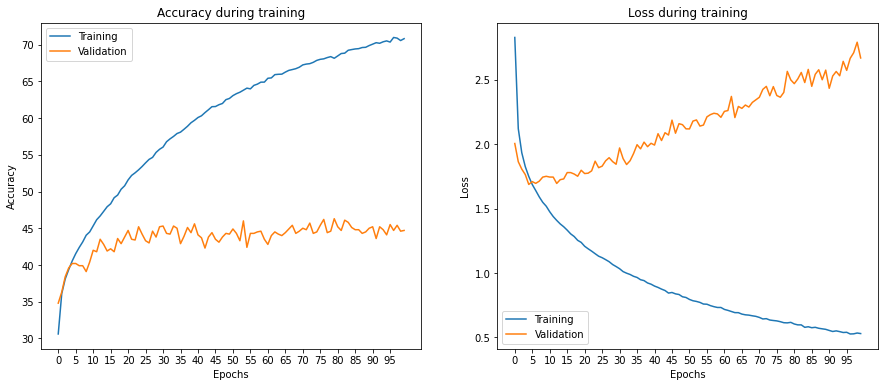

In [ ]:
# plotting
fig, ax = plt.subplots(1,2,figsize=(15, 6))
ax[0].set_title("Accuracy during training")
ax[0].plot(accur, label="Training")
ax[0].plot(epoch_e_accur, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(range(0,num_epochs,5))
ax[0].set_xticklabels(range(0,num_epochs,5))
ax[0].legend()

ax[1].set_title("Loss during training")
ax[1].plot(losses, label="Training")
ax[1].plot(epoch_e_loss, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(0,num_epochs,5))
ax[1].set_xticklabels(range(0,num_epochs,5))
ax[1].legend()
plt.show()

In [ ]:
# Print info for the log

print (ts)
print (VQAmodel)
print (criterion)
print (optimizer)

20201115130529
VQAm1(
  (iEmbedding): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
  )
  (qEmbedding): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=1000, bias=True)
  )
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0011663507799970843
    lr: 0.0006983372960937498
    weight_decay: 0
)
